# Spotlight Search

Use change in pocket area to find the best pass rushers.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
DIR = "/workspace/nflbigdatabowl2023"
sys.path.append(DIR)

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ast import literal_eval

In [9]:
df_plays = pd.read_csv(f"{DIR}/data/raw/plays.csv")
df_tracking = pd.read_csv(f"{DIR}/data/processed/tracking_display.csv")
df_play_metrics = pd.read_csv(f"{DIR}/data/processed/play_metrics.csv")
df_areas = pd.read_csv(f"{DIR}/data/processed/pocket_areas.csv")
df_areas["pocket"] = df_areas["pocket"].apply(literal_eval)

## Pseudocode

1. Filter `play_metrics` to only the `before_end` time window
1. Augment `play_metrics` with the percentage change of the area between the window start and end
1. Filter `play_metrics` to only plays with a high pocket area loss according to percentage change
1. Augment `pocket_areas` with a column that contains the vertices from the pocket metadata, if any
1. Filter `pocket_areas` to only frames with vertices in the pocket metadata
1. Left join the filtered `play_metrics` to `pocket_areas` to get the vertices for the start and end frames
1. Filter the join result to only windows that have vertices for both their start and end frames
1. Augment the join result with `shapely` polygons from the vertices
1. Augment the join result the polygon difference between the start and end polygons
1. This result provides `spotlight_windows`, the spotlight area for each selected play window
1. Filter `tracking_display` to blockers and rushers
1. Left join `spotlight_windows` to `tracking_display` to get the filtered players for that frame
1. This result provides `spotlight_players`, the players that could be in the spotlight area
1. Augment the join result with an indicator column for whether or not each player is in the spotlight area
1. Filter the join result to players who are in the spotlight area
1. Aggregate the players in the spotlight area to calculate how many blockers are in the spotlight area
1. Aggregate the players in the spotlight area to calculate how many rushers are in the spotlight area
1. Left join `spotlight_windows` to the aggregated columns from `spotlight_players`
1. Left join `spotlight_windows` to `plays` to pull in additional dimensions about the play
1. Query the augmented `spotlight_windows` to find spotlight moments of interest

In [125]:
df_areas.head()

,gameId,playId,frameId,method,pocket,area
0,2021090900,97,1,passer_radius,"{'area': 104.72938933713064, 'metadata': {'rad...",104.729389
1,2021090900,97,2,passer_radius,"{'area': 104.01436284917375, 'metadata': {'rad...",104.014363
2,2021090900,97,3,passer_radius,"{'area': 103.95687170361305, 'metadata': {'rad...",103.956872
3,2021090900,97,4,passer_radius,"{'area': 104.9172565778155, 'metadata': {'radi...",104.917257
4,2021090900,97,5,passer_radius,"{'area': 105.33257512661999, 'metadata': {'rad...",105.332575


## Transformations

In [179]:
def get_spotlight_plays(df_play_metrics: pd.DataFrame) -> pd.DataFrame:
    df = pd.DataFrame(df_play_metrics)
    # 1. Filter play_metrics to only the before_end time window
    df = df[df["window_type"] == "before_end"]
    # 2. Augment play_metrics with the percentage change of the area between the window start and end
    df["percentage_change"] = (df["area_start"] - df["area_end"]) / df["area_start"]
    # Temporary: Add back window start and end frames
    frames_per_second = 10
    df["window_start"] = (df["time_start"] * frames_per_second).astype(int)
    df["window_end"] = (df["time_end"] * frames_per_second).astype(int)
    return df.reset_index()

In [180]:
def get_frame_vertices(df_areas: pd.DataFrame) -> pd.DataFrame:
    df = pd.DataFrame(df_areas)
    # 4. Augment pocket_areas with a column that contains the vertices from the pocket metadata, if any
    df["vertices"] = df["pocket"].apply(lambda p: p.get("metadata", {}).get("vertices"))
    # 5. Filter pocket_areas to only frames with vertices in the pocket metadata
    df = df[df["vertices"].notna()]
    df = df[["gameId", "playId", "frameId", "vertices"]]
    return df.reset_index()

In [191]:
from shapely import Polygon


def get_spotlight_windows(df_spotlight_plays: pd.DataFrame, df_frame_vertices: pd.DataFrame) -> pd.DataFrame:
    # 3. Filter play_metrics to only plays with a high pocket area loss according to percentage change
    df_left = df_spotlight_plays[df_spotlight_plays["percentage_change"] >= 0.99]
    # 6. Left join the filtered play_metrics to pocket_areas to get the vertices for the start and end frames
    play_keys = ["gameId", "playId"]
    df = (
        df_left
            .merge(
                df_frame_vertices,
                left_on=play_keys + ["window_start"],
                right_on=play_keys + ["frameId"],
                how="left",
            )
            .drop(columns=["frameId"])
            .rename(columns={"vertices": "vertices_start"})
            .merge(
                df_frame_vertices,
                left_on=play_keys + ["window_end"],
                right_on=play_keys + ["frameId"],
                how="left",
            )
            .drop(columns=["frameId"])
            .rename(columns={"vertices": "vertices_end"})
    )
    # 7. Filter the join result to only windows that have vertices for both their start and end frames
    df = df[df["vertices_start"].notna() & df["vertices_end"].notna()]
    # 8. Augment the join result with shapely polygons from the vertices
    df["polygon_start"] = df["vertices_start"].apply(lambda v: Polygon(v))
    df["polygon_end"] = df["vertices_end"].apply(lambda v: Polygon(v))
    # 9. Augment the join result the polygon difference between the start and end polygons
    def get_polygon_difference(polygon_start, polygon_end):
        return polygon_start.difference(polygon_end)
    
    vec_polygon_difference = np.vectorize(get_polygon_difference)
    df["polygon_difference"] = vec_polygon_difference(df["polygon_start"], df["polygon_end"])
    # 10. This result provides spotlight_windows, the spotlight area for each selected play window
    return df

## Exploration

In [182]:
default_area = "adaptive_pocket_area"
query_area = f"method == '{default_area}'"
df_play_metrics_default = df_play_metrics.query(query_area)
df_areas_default = df_areas.query(query_area)

In [183]:
df_spotlight_plays = get_spotlight_plays(df_play_metrics_default)

In [184]:
df_frame_vertices = get_frame_vertices(df_areas_default)

In [192]:
df_spotlight_windows = get_spotlight_windows(df_spotlight_plays, df_frame_vertices)

In [193]:
df_spotlight_windows.head()

,index_x,gameId,playId,method,window_type,median_area,average_area,area_start,frame_start,frame_end,...,percentage_change,window_start,window_end,index_y,vertices_start,index,vertices_end,polygon_start,polygon_end,polygon_difference
0,2066,2021091200,4041,adaptive_pocket_area,before_end,13.45090,11.371738,18.60865,6.0,38.0,...,0.995835,18,38,382450,"[(22.8, 37.83), (26.13, 35.629999999999995), (...",382470.0,"[(27.11, 37.269999999999996), (26.96, 35.98999...","POLYGON ((22.8 37.83, 26.13 35.629999999999995...","POLYGON ((27.11 37.269999999999996, 26.96 35.9...","POLYGON ((26.13 35.629999999999995, 22.8 37.83..."
1,2266,2021091201,476,adaptive_pocket_area,before_end,4.88725,7.068369,20.97240,6.0,38.0,...,0.993832,18,38,383168,"[(25.69, 39.0), (29.68, 37.45), (33.31, 41.180...",383188.0,"[(30.23, 34.94), (28.64, 35.230000000000004), ...","POLYGON ((25.69 39, 29.68 37.45, 33.31 41.1800...","POLYGON ((30.23 34.94, 28.64 35.23000000000000...","POLYGON ((27.02 41.42, 30.09 42.23999999999999..."
3,3356,2021091202,815,adaptive_pocket_area,before_end,12.65700,8.214405,17.94425,6.0,35.0,...,0.992477,15,35,386487,"[(26.303333333333335, 32.19), (29.363333333333...",386507.0,"[(30.953333333333337, 25.2), (29.5633333333333...","POLYGON ((26.303333333333335 32.19, 29.3633333...","POLYGON ((30.953333333333337 25.2, 29.56333333...","POLYGON ((28.223333333333336 32.8, 32.23333333..."
4,3416,2021091202,1021,adaptive_pocket_area,before_end,20.86270,17.228940,20.17655,6.0,33.0,...,0.990102,13,33,386642,"[(25.783333333333335, 36.35), (29.203333333333...",386662.0,"[(29.593333333333337, 32.58), (29.323333333333...","POLYGON ((25.783333333333335 36.35, 29.2033333...","POLYGON ((29.593333333333337 32.58, 29.3233333...","POLYGON ((27.313333333333336 37.23, 30.8333333..."
5,4031,2021091202,3420,adaptive_pocket_area,before_end,3.57460,5.918930,19.74545,6.0,41.0,...,0.992137,21,41,388527,"[(25.39, 42.31999999999999), (29.68, 39.47), (...",388547.0,"[(28.38, 35.61), (26.38, 36.459999999999994), ...","POLYGON ((25.39 42.31999999999999, 29.68 39.47...","POLYGON ((28.38 35.61, 26.38 36.45999999999999...","POLYGON ((26.81 43.269999999999996, 29.45 43.5..."


In [132]:
(
    df_spotlight_plays
        .query(f"method == '{default_area}'")
        [["playId", "gameId", "time_start", "time_end", "area_start", "area_end", "percentage_change"]]
        .sort_values(by=["percentage_change"], ascending=False)
        .head(10)
)

,playId,gameId,time_start,time_end,area_start,area_end,percentage_change
8871,2766,2021091207,1.0,3.0,20.78395,0.001050,0.999949
17931,434,2021091902,1.7,3.7,17.89975,0.004300,0.999760
16726,2284,2021091900,2.6,4.6,15.10230,0.013090,0.999133
15871,3185,2021091600,1.9,3.9,23.90585,0.021468,0.999102
2526,1446,2021091201,2.6,4.6,11.49930,0.010577,0.999080
19081,2368,2021091903,1.4,3.4,10.06465,0.009320,0.999074
20021,1991,2021091904,1.5,3.5,16.47230,0.024500,0.998513
8946,2982,2021091207,1.8,3.8,20.54810,0.035700,0.998263
5586,1775,2021091204,2.7,4.7,16.93720,0.034000,0.997993
17011,3584,2021091900,1.7,3.7,21.47105,0.043700,0.997965


## Visualizations

In [119]:
from matplotlib.ticker import MultipleLocator


def plot_area_percentage_change_distribution(ser, cumulative: bool = False):
    # Note, all values outside the bin range will go into the
    # last bin on each side, possibly skewing the numbers.
    # To address this, we add one more bin to each side of the
    # desired range, so that those bins will contain outliers.
    bin_size = 0.1
    if cumulative:
        bin_size = 0.01
    bin_min = -2.0
    bin_max = 1.0
    bins = np.arange(bin_min - bin_size, bin_max + bin_size, bin_size)
    
    hist, bin_edges = np.histogram(ser, bins)
    hist_percentage = 100 * hist / hist.sum()
    bars = hist_percentage
    if cumulative:
        bars = hist_percentage.cumsum()

    fig, ax = plt.subplots(1, 1)
    pal = sns.hls_palette(1)

    ax.bar(
        x=bin_edges[1:],
        height=bars,
        # Use edge align with negative bin width so that
        # horizontal axis tick matches the bin edge.
        width=(-1 * bin_size),
        align="edge",
        color=pal[0]
    )

    ax.set_xlabel("Pocket Area % Change in Ending Window")
    ax.set_ylabel("Percentage of Passing Plays")
    if cumulative:
        ax.set_ylabel("Cumulative Percentage of Passing Plays")

    ax.set_ylim(0, bars.max() * 1.05)
    
    ax.xaxis.set_major_locator(MultipleLocator(2 * bin_size))
    ax.xaxis.set_minor_locator(MultipleLocator(bin_size))
    ax.yaxis.set_major_locator(MultipleLocator(2))
    ax.yaxis.set_minor_locator(MultipleLocator(1))
    if cumulative:
        ax.xaxis.set_major_locator(MultipleLocator(20 * bin_size))
        ax.xaxis.set_minor_locator(MultipleLocator(10 * bin_size))
        ax.yaxis.set_major_locator(MultipleLocator(10))
        ax.yaxis.set_minor_locator(MultipleLocator(5))

    ax.axvline(0, linestyle="--", color="black")
    ax.grid(which="both", linestyle="--", color="lightgray")

    fig.set_size_inches(12, 6)
    plt.show()

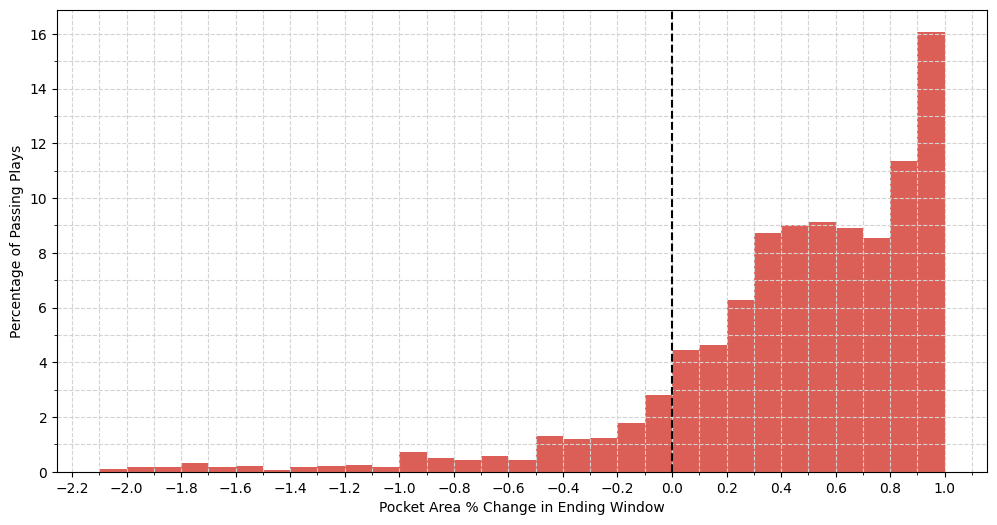

In [136]:
ser = df_spotlight_plays.query(f"method == '{default_area}'")["percentage_change"]
plot_area_percentage_change_distribution(ser)

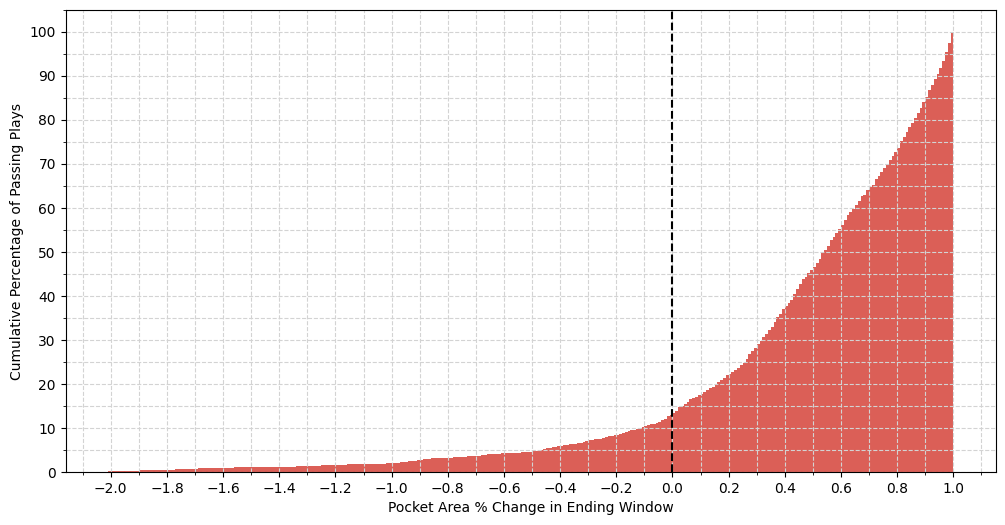

In [121]:
plot_area_percentage_change_distribution(ser, cumulative=True)